## Generalized ARMA(p,q) Model in PyMC: A Tutorial

This notebook demonstrates how to use the generalized ARMA(p,q) model implemented in PyMC, through PyTensor's efficient `scan` function for recursion.


## Setup and Imports

In [25]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from pytensor.scan import scan
from pytensor import tensor as pt


## The ARMA(p,q) function

The reason I explicitly write out the function here is to show you how it looks like. 

It is pretty simple, and hopefully I did a good job documenting it. 

*You might want to:*
- Play around with sampler settings.
- Play around with priors.
- Etc.

In [ ]:

def arma_p_q_model(series, 
                   p=1, 
                   q=1, 
                   name=None,
                   plot_trace=False):
    """
    Fit an ARMA(p,q) model to the given time series data using PyMC3.

    Parameters:
    ----------
    series : array-like
        The time series data to fit the ARMA(p,q) model to.
    p : int
        The order of the autoregressive (AR) part of the model.
    q : int
        The order of the moving average (MA) part of the model.
    name : str, optional
        The name of the model. If None, a default name will be generated.
    plot_trace : bool, optional
        Whether to plot the trace of the posterior samples.

    Returns:
    -------
    model : pymc3.Model
        The fitted ARMA model.
    trace : arviz.InferenceData
        The posterior samples from the fitted model.
    """
    
    x = np.asarray(series).astype(float)
    x = x[~np.isnan(x)]
    T = len(x)

    if T < 1 + 2 + 30:
        return None  # Need at least 30 samples beyond p+q
    
    if name is None:
        name = f"arma_{p}_{q}_model"

    y_obs = x[max(p, q):]
    x_shared = pt.as_tensor_variable(x)

    with pm.Model() as model:
        # Parameter Priors
        #-----------------------------------------------
        # AR(p) coefficients: phi_1, phi_2, ..., phi_p
        phi = pm.TruncatedNormal("phi", mu=0.0, sigma=1.0, lower=-1, upper=1.99, shape=(p,))
        # MA(q) coefficients: theta_1, theta_2, ..., theta_q
        theta = pm.TruncatedNormal("theta", mu=0.0, sigma=1.0, lower=-1, upper=1.99, shape=(q,))
        # Error term: sigma
        sigma = pm.HalfNormal("sigma", sigma=1.0)

        # Initial errors: eps_{t-q},..., eps_{t-1}
        eps_init = pm.Normal("eps_init", mu=0.0, sigma=0.1, shape=(q,))
        #eps_init = pt.zeros(q)  # Initialize to zero


        # Step function for the scan
        #------------------------------------------------
        def step(t_idx, eps_hist, phi, theta):            
            # We redefine the lagged observations in x to depent on p
            x_lag = x_shared[t_idx - p:t_idx][::-1] # note: we reverse the order so that the 1st element is the most recent lagged value

            ar_term = pt.sum(phi * x_lag)
            ma_term= pt.sum(theta * eps_hist[::-1]) # note: we reverse the order so that the 1st element is the most recent lagged value.

            mu_t = ar_term + ma_term
            eps_t = x_shared[t_idx] - mu_t

            # Shift errors left and append eps_t
            new_eps_hist = pt.set_subtensor(eps_hist[:-1], eps_hist[1:])
            new_eps_hist = pt.set_subtensor(new_eps_hist[-1], eps_t)

            return new_eps_hist, mu_t

        scan_indices = pt.arange(max(p, q), T)

        (eps_hist_seq, mu_seq), _ = scan(
            fn=step,
            sequences=scan_indices,
            outputs_info=[eps_init, None],
            non_sequences=[phi, theta]
        )

        # Observation equation
        #------------------------------------------------
        pm.Normal("obs", mu=mu_seq, sigma=sigma, observed=y_obs)


        # Sampling from the posterior
        #------------------------------------------------
        trace = pm.sample(
            700, tune=400, target_accept=0.9,
            return_inferencedata=True, discard_tuned_samples=True,
            chains=4, cores=4
        )

    if plot_trace:
        az.plot_trace(trace, figsize=(12, 8))
        plt.suptitle(f"Trace Plots for ARMA({p},{q}) Model Parameters", fontsize=14)
        plt.tight_layout()
        plt.legend(loc="upper right")
        plt.show()

    return model, trace

## Generating example data
For a simple example, let's generate some synthetic ARMA(1,2) data.

In [ ]:
np.random.seed(42)
n = 300

# Simulating ARMA(1,2) data
ar_coefs = [0.5]
ma_coefs = [0.4, -0.3]
arma_process = np.random.randn(n)

for t in range(2, n):
    arma_process[t] += ar_coefs[0] * arma_process[t - 1] \
                     + ma_coefs[0] * np.random.randn() \
                     + ma_coefs[1] * np.random.randn()




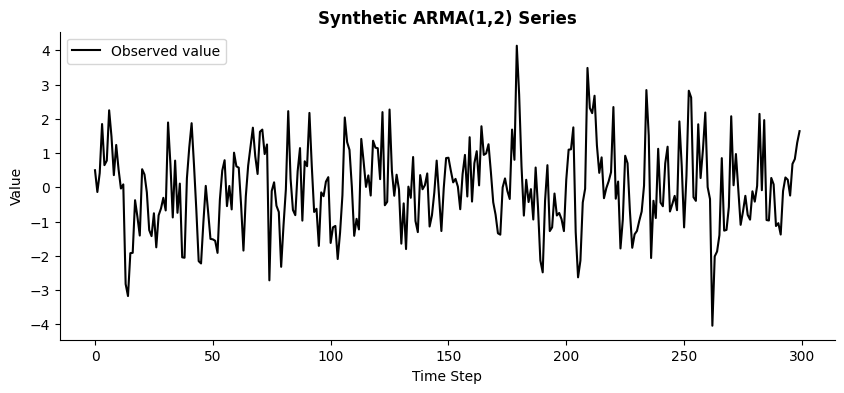

In [23]:
fig = plt.figure(figsize=(10, 4))
plt.plot(arma_process, label="Observed value", color="black")
plt.title("Synthetic ARMA(1,2) Series", fontsize=12, fontweight="bold")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc="upper left")
plt.show()

The above looks like a nice and stationary time-series. We continue onwards.

## Fitting the ARMA Model using the provided function

We fit an ARMA(1,2) model to the synthetic data. We also set `plot_trace=True`, so that we see the trace and any potential issues.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, theta, sigma, eps_init]


Sampling 4 chains for 400 tune and 700 draw iterations (1_600 + 2_800 draws total) took 91 seconds.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


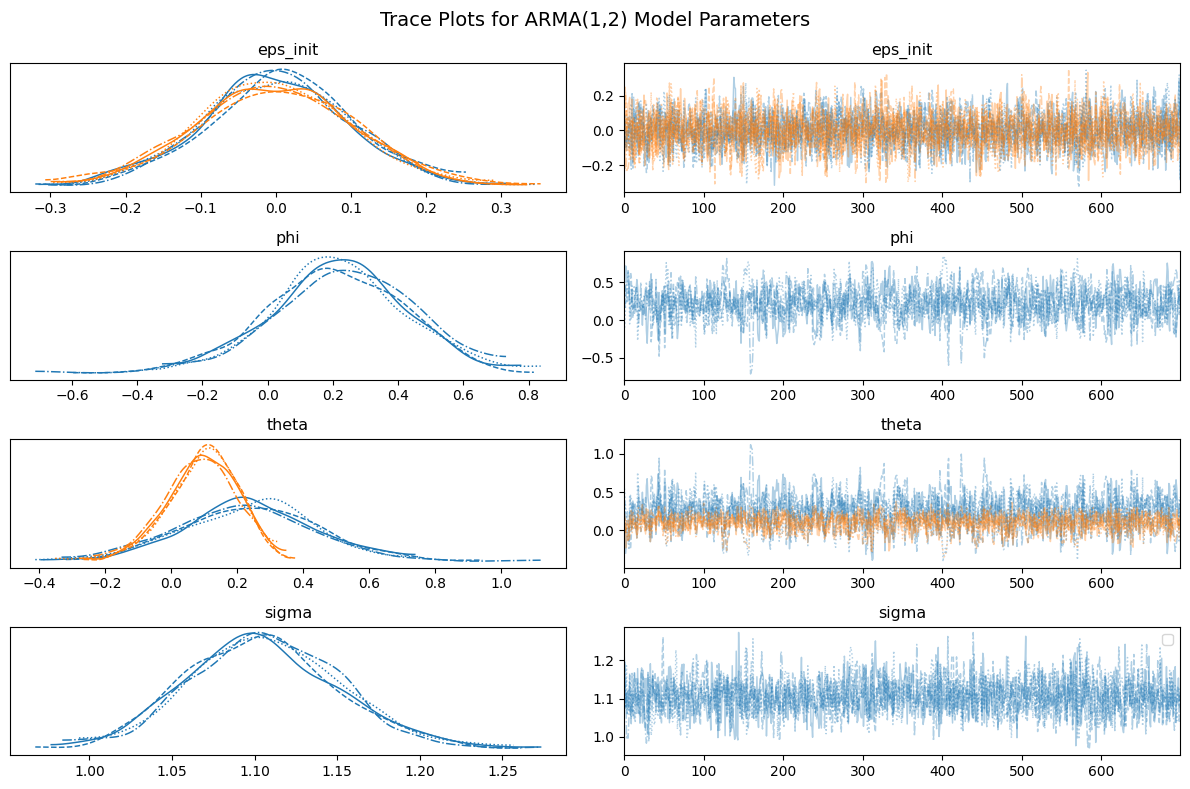

In [28]:
model, trace = arma_p_q_model(arma_process, p=1, q=2, plot_trace=True)

In [29]:
az.summary(trace, hdi_prob=0.95).round(2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eps_init[0],0.00,0.10,-0.19,0.19,0.00,0.0,1988.0,1798.0,1.0
eps_init[1],-0.00,0.10,-0.20,0.21,0.00,0.0,2419.0,1770.0,1.0
phi[0],0.22,0.21,-0.20,0.64,0.01,0.0,995.0,1115.0,1.0
theta[0],0.24,0.21,-0.18,0.64,0.01,0.0,1032.0,1144.0,1.0
theta[1],0.09,0.11,-0.11,0.31,0.00,0.0,1085.0,1109.0,1.0
sigma,1.11,0.05,1.02,1.20,0.00,0.0,2106.0,1677.0,1.0
